In [3]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.visualization import plot_histogram
from qiskit import BasicAer

In [4]:
def execute_circuit(circuit, backend=Aer.get_backend('qasm_simulator'), shots=1024):
    job = execute(circuit, backend=backend, shots=shots)
    result = job.result()
    counts = result.get_counts(circuit)
    return counts

def count_to_prob(counts):
    shots = sum(counts.values())
    n_qubits = len(list(counts.keys())[0])
    probs = np.zeros(2**n_qubits)
    for key, value in counts.items():
        probs[int(key, 2)] = value/shots
    return probs

def get_statevector(circuit, backend=Aer.get_backend('statevector_simulator')):
    job = execute(circuit, backend=backend)
    result = job.result()
    statevector = result.get_statevector(circuit)
    return statevector

def get_unitary(circuit, backend=Aer.get_backend('unitary_simulator')):
    job = execute(circuit, backend=backend)
    result = job.result()
    unitary = result.get_unitary(circuit)
    return unitary

# Grover's Algorithm

## Problem Statement

Grover's algorithm is a quantum algorithm that finds with high probability the unique input to a black box function that produces a particular output value, using just $O(\sqrt{N})$ evaluations of the function, where $N$ is the size of the function's domain. It was devised by Lov Grover in 1996. 

## The Problem

Given a $N$ element list, find the index of a given element $x$ in the list wich satisfies a certain function $f(x)$ such that $f(x) = 1$.

**Elements of the list:** [0, 1, 2, 3, 4, 5, 6, 7]

**Element to be found:** 5

$$ f(x) = \begin{cases} 1 & \text{if } x = 5 \\ 0 & \text{otherwise} \end{cases} $$


In [5]:
list_elements = np.arange(0, 8)
print(f'List of elements: {list_elements}')

List of elements: [0 1 2 3 4 5 6 7]


## Grover's Iterator

The Grover's Iterator is defined as:

$$ G = U_d U_f $$

where $U_f$ is the oracle and $U_d$ is the diffusion operator.

### Oracle

The oracle is a unitary operator that flips the phase of the state $|x\rangle$ if $f(x) = 1$.

$$ U_f\ket{x} = (-1)^{f(x)}\ket{x} $$
therefore

$$U_f\ket{5} = -\ket{5}$$



In [6]:
def Oracle(n_qubits, element):

    qr = QuantumRegister(n_qubits + 1, 'q')
    q_ancilla = qr[-1]
    q_x = qr[:-1]

    qc = QuantumCircuit(qr, name=f'$f({element})=1$')

    bit_string = np.binary_repr(element, n_qubits)[::-1]
    [qc.x(q_x[i]) for i in range(n_qubits) if bit_string[i] == '0']
    qc.mcx(q_x, q_ancilla)
    [qc.x(q_x[i]) for i in range(n_qubits) if bit_string[i] == '0']

    oracle = qc.to_gate()

    return oracle

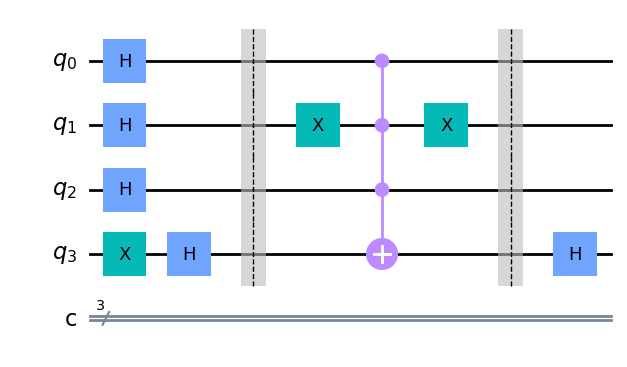

In [7]:
n_qubits = np.ceil(np.log2(np.max(list_elements))).astype(int)

qr = QuantumRegister(n_qubits + 1, 'q')
cr = ClassicalRegister(n_qubits, 'c')

qc = QuantumCircuit(qr, cr, name='Oracle Test')

q_ancilla = qr[-1]
q_x = qr[:-1]

qc.x(q_ancilla)
qc.h(qr)
qc.barrier()
qc.append(Oracle(n_qubits, 5), qr)
qc.barrier()

qc.h(q_ancilla)
#qc.measure(q_x, cr)

qc.decompose(gates_to_decompose='$f(5)=1$').draw(output='mpl')

Amplitudes: [ 0.35355339  0.35355339  0.35355339  0.35355339  0.35355339 -0.35355339
  0.35355339  0.35355339]


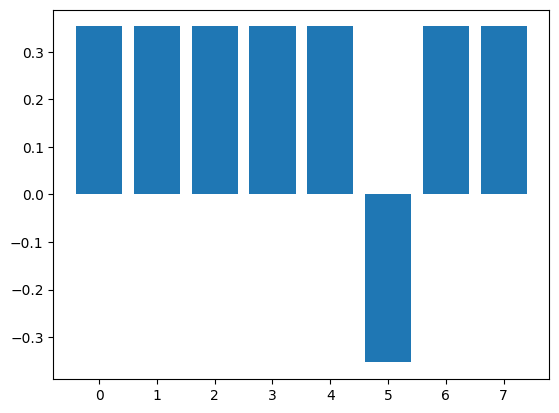

In [8]:
amplitudes = get_statevector(qc)
amp_vals = np.array(amplitudes.measure([3])[1]).real
amp_vals = amp_vals[2 ** n_qubits:]

print(f'Amplitudes: {amp_vals}')

plt.bar(np.arange(0, len(amp_vals)), amp_vals);

### Diffusion Operator

The diffusion operator is a unitary operator that amplifies the amplitude of the marked element and reduces the amplitude of the other elements.

$$ U_d = 2\ket{\psi}\bra{\psi} - I $$

where $\ket{\psi}$ is the equal superposition state.

$$ \ket{\psi} = \frac{1}{\sqrt{N}}\sum_{x=0}^{N-1}\ket{x} $$

but since it can be written in terms of the Hadamard operator

$$ \ket{\psi} = H^{\otimes n}\ket{0} $$

and 

$$HH = I$$

then,

$$ U_d = H^{\otimes n}\left(2\ket{0}\bra{0} - I\right)H^{\otimes n}$$

### What is the effect of $\left(2\ket{0}\bra{0} - I\right)$?

$$\left(2\ket{0}\bra{0} - I\right)\ket{x} = \begin{cases} \ket{0} & \text{if } x = 0 \\ -\ket{x} & \text{otherwise} \end{cases}$$

### Qiskit Implementation

The diffusion operator in a quantum circuit is more easily implemented as follows:

$$ U_d = -H^{\otimes n}\left(2\ket{0}\bra{0} - I\right)H^{\otimes n} $$

such that

$$ -\left(2\ket{0}\bra{0} - I\right)\ket{x} = \begin{cases} -\ket{0} & \text{if } x = 0 \\ \ket{x} & \text{otherwise} \end{cases}$$

Note that this operator is not the same as the one defined above, but since this just adds a global phase of $e^{i\pi}=-1$ to the state, it does not affect the outcome of the algorithm.

In [9]:
def diffuser(n_qubits):

    qr = QuantumRegister(n_qubits, 'q')
    qc = QuantumCircuit(qr, name='Diffuser')

    qc.h(qr)
    qc.x(qr)
    qc.h(qr[-1])
    qc.mcx(qr[:-1], qr[-1])
    qc.h(qr[-1])
    qc.x(qr)
    qc.h(qr)

    diffuser = qc.to_gate()

    return diffuser

### Grove's Iterator

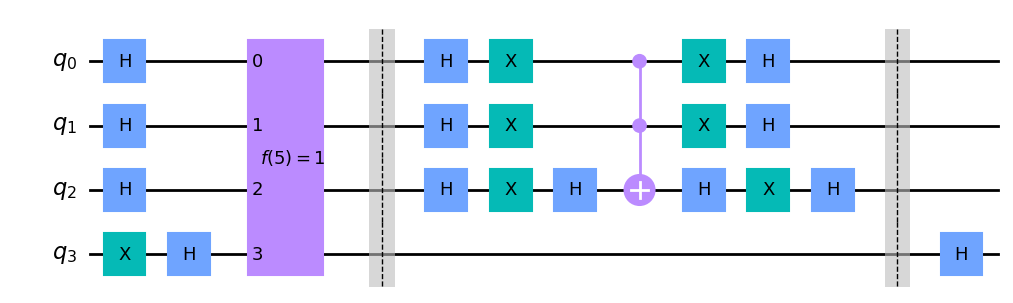

In [10]:
n_qubits = np.ceil(np.log2(np.max(list_elements))).astype(int)

qr = QuantumRegister(n_qubits + 1, 'q')
qc = QuantumCircuit(qr, name='Grover Test')

qc.x(qr[-1])
qc.h(qr)

qc.append(Oracle(n_qubits, 5), qr)
qc.barrier()
qc.append(diffuser(n_qubits), qr[:-1])

qc.barrier()
qc.h(qr[-1])

qc.decompose(gates_to_decompose='Diffuser').draw(output='mpl')

Amplitudes: [-0.1767767  -0.1767767  -0.1767767  -0.1767767  -0.1767767  -0.88388348
 -0.1767767  -0.1767767 ]


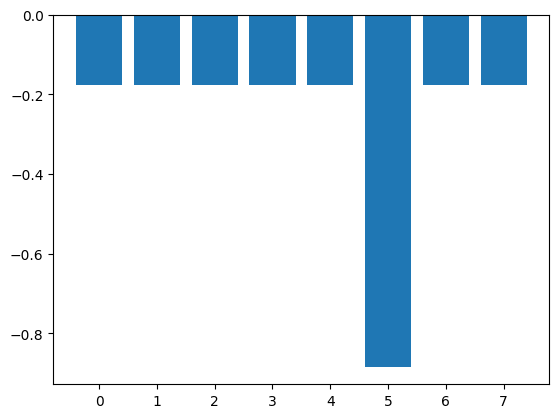

In [11]:
amplitudes = get_statevector(qc)
amp_vals = np.array(amplitudes.measure([3])[1]).real
amp_vals = amp_vals[2 ** n_qubits:]

print(f'Amplitudes: {amp_vals}')

plt.bar(np.arange(0, len(amp_vals)), amp_vals);

The number of iterations $k$ required to find the marked element is given by

$$ k = \left\lfloor\frac{\pi}{4}\sqrt{N}\right\rfloor $$

for $N=8$ the number of iterations is $k=2$.

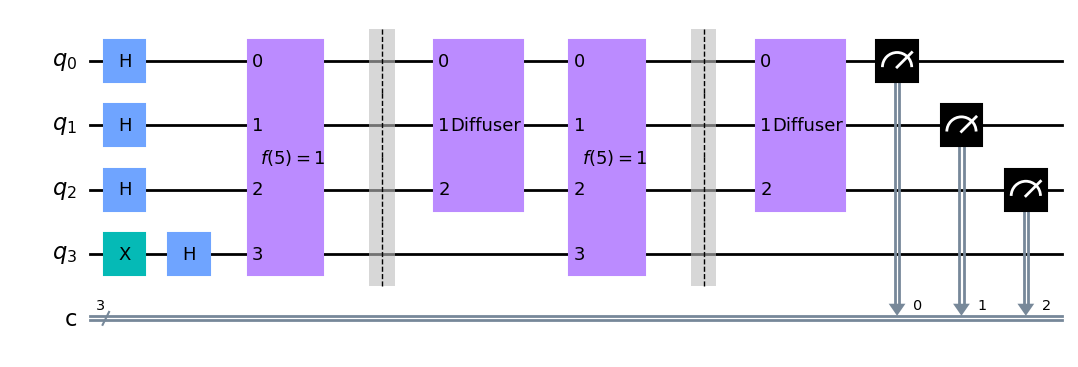

In [22]:
n_qubits = np.ceil(np.log2(np.max(list_elements))).astype(int)

qr = QuantumRegister(n_qubits + 1, 'q')
cr = ClassicalRegister(n_qubits, 'c')
qc = QuantumCircuit(qr, cr, name='Grover')

qc.x(qr[-1])
qc.h(qr)

for k in range(2):
    qc.append(Oracle(n_qubits, 5), qr)
    qc.barrier()
    qc.append(diffuser(n_qubits), qr[:-1])

qc.measure(qr[:-1], cr)

qc.draw(output='mpl')

Probabilities: [0.00878906 0.01074219 0.00976562 0.00585938 0.01464844 0.93554688
 0.00976562 0.00488281]


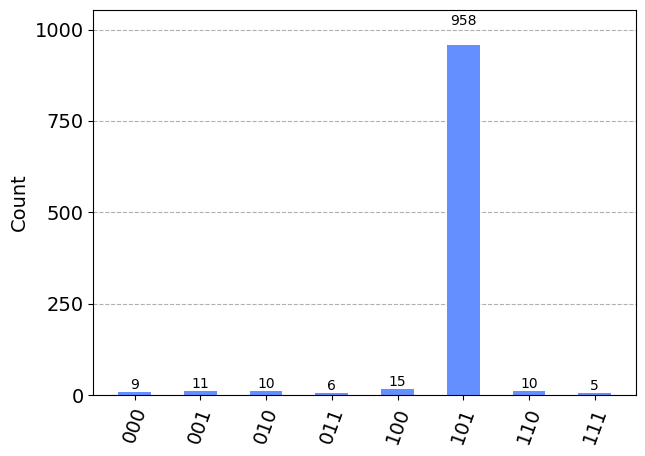

In [23]:
counts = execute_circuit(qc)
probs = count_to_prob(counts)

print(f'Probabilities: {probs}')

plot_histogram(counts)

# Satisfiability Problem

The satisfiability problem (SAT) is a classic problem in computer science. It is the first problem that was proven to be NP-complete. The problem consists in determining if there is an assignment of boolean values to variables such that a given boolean formula is satisfied.

## Boolean Formula

A boolean formula is a formula built from boolean variables and the logical operators AND ($\land$), OR ($\lor$) and NOT ($\neg$).

$$ \phi = A \land B $$

**Solve the Problem using Grover's Algorithm**